In [1]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid

import os
from os.path import join, dirname, exists
import pickle

import matplotlib.pyplot as plt

##Learning framework

You should know how to write this by now:
*    Train procedure
*    Validation procedure

In [2]:
def train(model, train_loader, optimizer, epoch, quiet, grad_clip=None):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses


def train_epochs(model, train_loader, test_loader, train_args, quiet=False):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet, grad_clip)
        test_loss = eval_loss(model, test_loader, quiet)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses


## Validation

In [26]:
def save_training_plot(train_losses, test_losses, title, fname=None):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    if fname is not None:
        savefig(fname)
    else:
        plt.show()

def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()

## 2D-Data

In [3]:
## Data from a Full Covariance Gaussian
def sample_Full_Covariance_Gaussian_1(count):
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


def sample_Full_Covariance_Gaussian_2(count):
    rand = np.random.RandomState(0)
    return [[-1.0, 2.0]] + (rand.randn(count, 2) * [[1.0, 5.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

## Data from a Diagonal Gaussian
def sample_Diagonal_Gaussian_1(count):
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_Diagonal_Gaussian_2(count):
    rand = np.random.RandomState(0)
    return [[-1.0, 2.0]] + rand.randn(count, 2) * [[1.0, 5.0]]

In [4]:
def sample_data(part, dset_id):
    assert dset_id in [1, 2]
    assert part in ['Full_Covariance', 'Diagonal']
    if part == 'Full_Covariance':
        if dset_id == 1:
            dset_fn = sample_Full_Covariance_Gaussian_1
        else:
            dset_fn = sample_Full_Covariance_Gaussian_2
    elif part == 'Diagonal':
        if dset_id == 1:
            dset_fn = sample_Diagonal_Gaussian_1
        else:
            dset_fn = sample_Diagonal_Gaussian_2
    else:
        raise NotImplementedError

    train_data, test_data = dset_fn(10000), dset_fn(2500)
    return train_data.astype('float32'), test_data.astype('float32')

Look at your data !

In [5]:
def visualize_data(part, dset_id):
    train_data, test_data = sample_data(part, dset_id)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('Train Data')
    ax1.scatter(train_data[:, 0], train_data[:, 1])
    ax2.set_title('Test Data')
    ax2.scatter(test_data[:, 0], test_data[:, 1])
    print(f'Dataset {part} {dset_id}')
    plt.show()

Use the visualize_data function to look at your data distributions

Dataset Full_Covariance 1


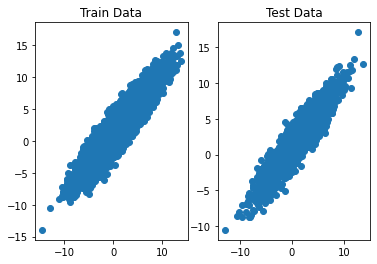

Dataset Full_Covariance 2


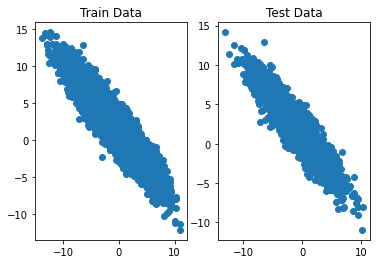

Dataset Diagonal 1


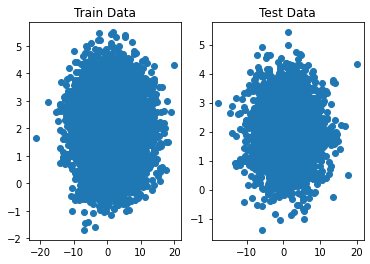

Dataset Diagonal 2


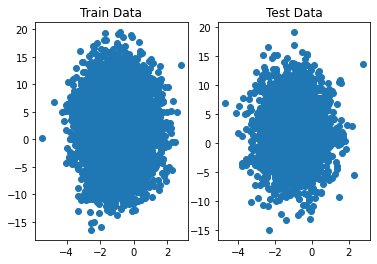

In [6]:
visualize_data('Full_Covariance', 1)
visualize_data('Full_Covariance', 2)
visualize_data('Diagonal', 1)
visualize_data('Diagonal', 2)


##Model: Fully Connected VAE

Write a MLP constructor which takes as input 

*   input_shape => expected input shape
*   output_shape => expected output shape
*   hiddens => List, List of the shape of your hidden layer



In [7]:
class MLP(nn.Module):
    def __init__(self, input_shape, output_shape, hiddens=[]):
        super().__init__()

        if isinstance(input_shape, int):
            input_shape = (input_shape,)
        if isinstance(output_shape, int):
            output_shape = (output_shape,)

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hiddens = hiddens

        model = []
        prev_h = np.prod(input_shape)
        for h in hiddens + [np.prod(output_shape)]:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.pop()
        self.net = nn.Sequential(*model)

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        return self.net(x).view(b, *self.output_shape)

Complete the Fully Connected VAE code

In [8]:
class FullyConnectedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, enc_hidden_sizes=[],
                 dec_hidden_sizes=[]):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLP(input_dim, 2 * latent_dim, enc_hidden_sizes)
        self.decoder = MLP(latent_dim, 2 * input_dim, dec_hidden_sizes)

    def loss(self, x):
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)

        # Compute reconstruction loss - Note that it may be easier for you
        # to use torch.distributions.normal to compute the log_prob
        recon_loss = 0.5 * np.log(2 * np.pi) + log_std_x + \
                     (x - mu_x) ** 2 * torch.exp(-2 * log_std_x) * 0.5
        recon_loss = recon_loss.sum(1).mean()

        # Compute KL
        kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda()
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()


Sample deterministically and with noise on both distributions (Full covariance and diagonal). What do you observe?

In [9]:
def plot_vae_training_plot(train_losses, test_losses, title, fname=None):
    elbo_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    elbo_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, elbo_train, label='-elbo_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')
    plt.plot(x_test, elbo_test, label='-elbo_test')
    plt.plot(x_test, recon_test, label='recon_loss_test')
    plt.plot(x_test, kl_test, label='kl_loss_test')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if fname is not None:
        savefig(fname)
    else:
        plt.show()

In [10]:
def FullyConnectedVAE_training(train_data, test_data):
    model = FullyConnectedVAE(2, 2, [128, 128], [128, 128]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=10, lr=1e-3), quiet=False)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)

    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise


In [11]:
def save_scatter_2d(data, title, fname=None):
    plt.figure()
    plt.title(title)
    plt.scatter(data[:, 0], data[:, 1])
    if fname is not None:
        savefig(fname)
    else:
        plt.show()

def show_results(part, dset_id):
    train_data, test_data = sample_data(part, dset_id)
    train_losses, test_losses, samples_noise, samples_nonoise = FullyConnectedVAE_training(train_data, test_data)
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, 'f'KL Loss: {test_losses[-1, 2]:.4f}')

    plot_vae_training_plot(train_losses, test_losses, f'FullyConnectedVAE Dataset {part} {dset_id} Train Plot')
    save_scatter_2d(samples_noise, title='Samples with Decoder Noise')
    save_scatter_2d(samples_nonoise, title='Samples without Decoder Noise')

Final -ELBO: 4.4876, Recon Loss: 2.9681, KL Loss: 1.5195


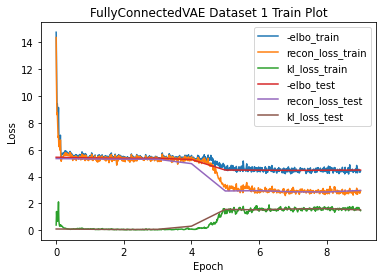

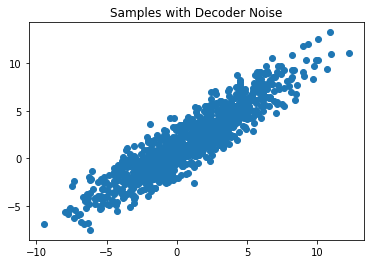

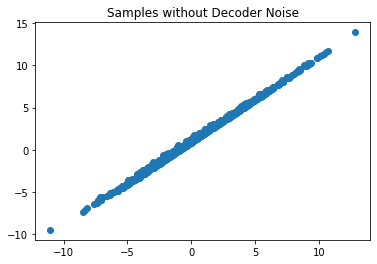

Final -ELBO: 4.7291, Recon Loss: 3.0243, KL Loss: 1.7048


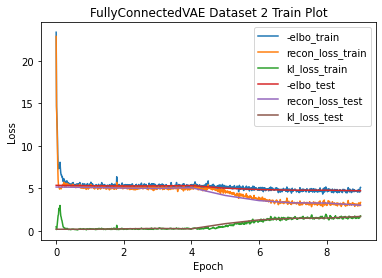

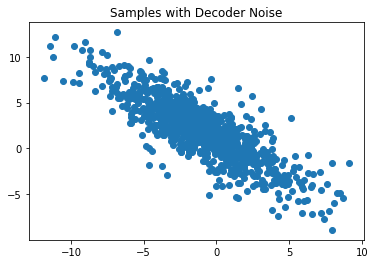

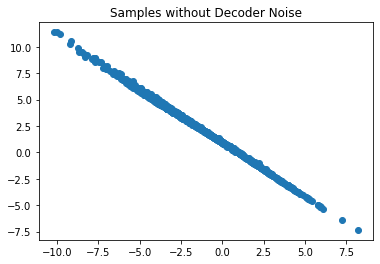

Final -ELBO: 4.4288, Recon Loss: 4.4196, KL Loss: 0.0092


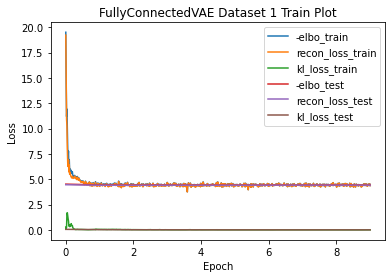

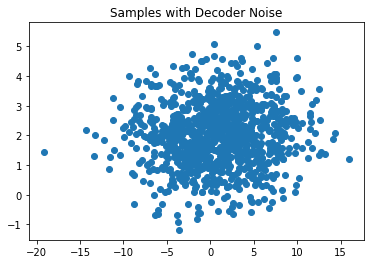

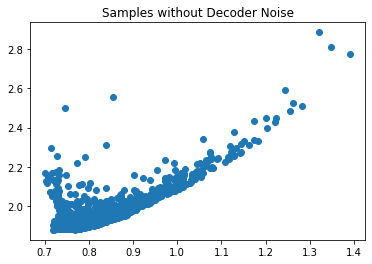

Final -ELBO: 4.4289, Recon Loss: 4.4198, KL Loss: 0.0091


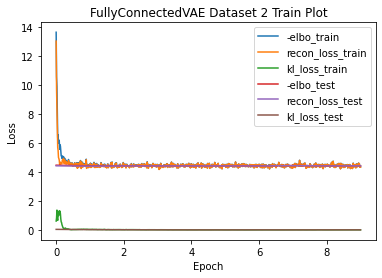

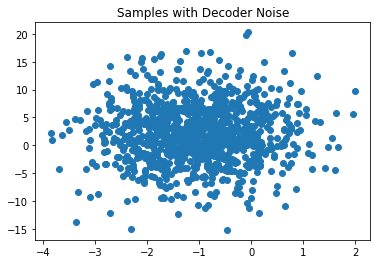

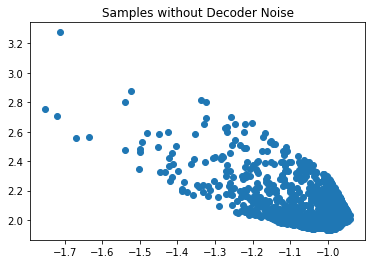

In [18]:
show_results('Full_Covariance', 1)
show_results('Full_Covariance', 2)
show_results('Diagonal', 1)
show_results('Diagonal', 2)

##Model: Convolutional VAE

Let's work on images as convolution works well with images (it's a common inductive bias with this type of data)! CIFAR10 will be our dataset.

Add Google Colab access to your Google Drive. Then copy the directory path to your data.
Finally visualize the dataset

In [12]:
def get_data_dir():
    return join('/content', 'drive', 'MyDrive', 'Thèse', 'lesson5')


In [13]:
def load_pickled_data(fname, include_labels=False):
    with open(fname, 'rb') as f:
        data = pickle.load(f)

    train_data, test_data = data['train'], data['test']
    if 'mnist.pkl' in fname or 'shapes.pkl' in fname:
        # Binarize MNIST and shapes dataset
        train_data = (train_data > 127.5).astype('uint8')
        test_data = (test_data > 127.5).astype('uint8')
    if 'celeb.pkl' in fname:
        train_data = train_data[:, :, :, [2, 1, 0]]
        test_data = test_data[:, :, :, [2, 1, 0]]
    if include_labels:
        return train_data, test_data, data['train_labels'], data['test_labels']
    return train_data, test_data

def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()

def visualize_cifar10():
    data_dir = get_data_dir()
    train_data, test_data = load_pickled_data(join(data_dir, 'cifar10.pkl'))
    idxs = np.random.choice(len(train_data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title='CIFAR10 Samples')

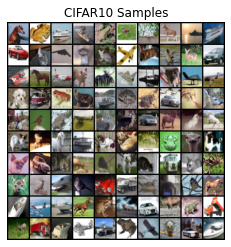

In [14]:
visualize_cifar10()

Ok now, let's code a convolutional VAE: first let's build the convolutional encoder

In [15]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std

The decoder is similar but used a different function: nn.ConvTranspose2d. Any insights why?

In [16]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(latent_dim, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        out = self.deconvs(out)
        return out

Let's build the VAE then:

In [17]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.latent_size = latent_size
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = ConvDecoder(latent_size, input_shape)

    def loss(self, x):
        x = 2 * x - 1
        mu, log_std = self.encoder(x)
        z = torch.randn_like(mu) * log_std.exp() + mu
        x_recon = self.decoder(z)

        recon_loss = F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1).sum(1).mean()
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda()
            samples = torch.clamp(self.decoder(z), -1, 1)
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5


It's time to train.

In [18]:
def ConvVAE_train(train_data, test_data):
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = ConvVAE((3, 32, 32), 16).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3), quiet=False)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255.

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        x_recon = torch.clamp(model.decoder(z), -1, 1)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
        interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
    interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    return train_losses, test_losses, samples, reconstructions, interps

Final -ELBO: 240.2479, Recon Loss: 209.4285, KL Loss: 30.8194


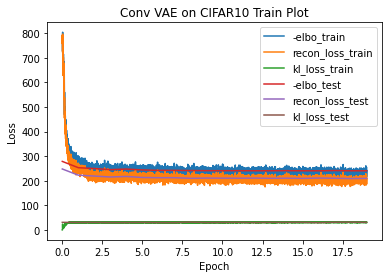

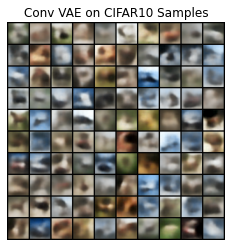

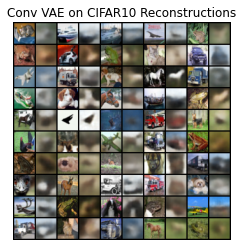

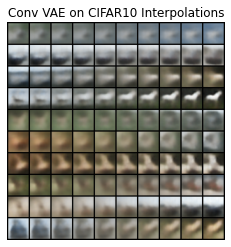

In [35]:
data_dir = get_data_dir()
train_data, test_data = load_pickled_data(join(data_dir, 'cifar10.pkl'))
train_losses, test_losses, samples, reconstructions, interpolations = ConvVAE_train(train_data, test_data)
samples, reconstructions, interpolations = samples.astype('float32'), reconstructions.astype('float32'), interpolations.astype('float32')
print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, 'f'KL Loss: {test_losses[-1, 2]:.4f}')
plot_vae_training_plot(train_losses, test_losses, f'Conv VAE on CIFAR10 Train Plot')
show_samples(samples, title=f'Conv VAE on CIFAR10 Samples')
show_samples(reconstructions, title=f'Conv VAE on CIFAR10 Reconstructions')
show_samples(interpolations, title=f'Conv VAE on CIFAR10 Interpolations')

## [VQ-VAE](https://arxiv.org/abs/1711.00937)

If you want to be reminded about the technique, you can look at the paper or the [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) which summerize a lot of things about VAEs.

Basically, you have an encoder which produces latents that are feed to a decoder. Those latents are forced to be close of quantized centers called a codebook.
Finally, the priors of the VAE are trained using a PixelCNN.


In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1)
        )
      
    def forward(self, x):
        return x + self.net(x)

What is quantization?

In [20]:
def quantize(images, n_bits):
    images = np.floor(images / 256. * 2 ** n_bits)
    return images.astype('uint8')

Codebook creation:

In [21]:
class Quantize(nn.Module):

    def __init__(self, size, code_dim):
        super().__init__()
        self.embedding = nn.Embedding(size, code_dim)
        self.embedding.weight.data.uniform_(-1./size,1./size)

        self.code_dim = code_dim
        self.size = size

    def forward(self, z):
        b, c, h, w = z.shape
        weight = self.embedding.weight

        flat_inputs = z.permute(0, 2, 3, 1).contiguous().view(-1, self.code_dim)
        distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) \
                    - 2 * torch.mm(flat_inputs, weight.t()) \
                    + (weight.t() ** 2).sum(dim=0, keepdim=True)
        encoding_indices = torch.max(-distances, dim=1)[1]
        encoding_indices = encoding_indices.view(b, h, w)
        quantized = self.embedding(encoding_indices).permute(0, 3, 1, 2).contiguous()

        return quantized, (quantized - z).detach() + z, encoding_indices

Time to build the VAE

In [22]:
class VectorQuantizedVAE(nn.Module):
    def __init__(self, code_dim, code_size):
        super().__init__()
        self.code_size = code_size

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),
            ResidualBlock(256),
            ResidualBlock(256),
        )

        self.codebook = Quantize(code_size, code_dim)

        self.decoder = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode_code(self, x):
        with torch.no_grad():
            x = 2 * x - 1
            z = self.encoder(x)
            indices = self.codebook(z)[2]
            return indices

    def decode_code(self, latents):
        with torch.no_grad():
            latents = self.codebook.embedding(latents).permute(0, 3, 1, 2).contiguous()
            return self.decoder(latents).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5

    def forward(self, x):
        z = self.encoder(x)
        e, e_st, _ = self.codebook(z)
        x_tilde = self.decoder(e_st)

        diff1 = torch.mean((z - e.detach()) ** 2)
        diff2 = torch.mean((e - z.detach()) ** 2)
        return x_tilde, diff1 + diff2

    def loss(self, x):
        x = 2 * x - 1
        x_tilde, diff = self(x)
        recon_loss = F.mse_loss(x_tilde, x)
        loss = recon_loss + diff
        return OrderedDict(loss=loss, recon_loss=recon_loss, reg_loss=diff)

Let's take a PixelCNN from the autoregressive notebook. Actually it is a bit different due to the fact we are using multiple color channels (instead of grayscale images)

In [23]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()


class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, conditional_size=None, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

        if conditional_size is not None:
            self.cond_op = nn.Linear(conditional_size, self.out_channels)

    def forward(self, input, cond=None):
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
        if cond is not None:
            cond = self.cond_op(cond)
            out = out + cond.view(cond.shape[0], self.out_channels, 1, 1)
        return out

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1


class PixelCNNResBlock(nn.Module):
    def __init__(self, dim, conditional_size=None):
        super().__init__()
        self.block = nn.ModuleList([
            LayerNorm(dim),
            nn.ReLU(),
            MaskConv2d('B', dim, dim // 2, 1, conditional_size=conditional_size),
            LayerNorm(dim // 2),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim // 2, 3, padding=1, 
                       conditional_size=conditional_size),
            LayerNorm(dim // 2),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim, 1, conditional_size=conditional_size)
        ])

    def forward(self, x, cond=None):
        out = x
        for layer in self.block:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return x + out


class PixelCNN(nn.Module):
    def __init__(self, input_shape, code_size, dim=256, n_layers=7,
                 conditional_size=None):
        super().__init__()
        self.embedding = nn.Embedding(code_size, dim)
        model = nn.ModuleList([MaskConv2d('A', dim, dim, 7, padding=3,
                                          conditional_size=conditional_size),
                               LayerNorm(dim), nn.ReLU()])
        for _ in range(n_layers - 1):
            model.append(PixelCNNResBlock(dim, conditional_size=conditional_size))
        model.extend([LayerNorm(dim), nn.ReLU(), MaskConv2d('B', dim, 512, 1, conditional_size=conditional_size),
                      nn.ReLU(), MaskConv2d('B', 512, code_size, 1,
                                            conditional_size=conditional_size)])
        self.net = model
        self.input_shape = input_shape
        self.code_size = code_size

    def forward(self, x, cond=None):
        out = self.embedding(x).permute(0, 3, 1, 2).contiguous()
        for layer in self.net:
            if isinstance(layer, MaskConv2d) or isinstance(layer, PixelCNNResBlock):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out

    def loss(self, x, cond=None):
        return OrderedDict(loss=F.cross_entropy(self(x, cond=cond), x))

    def sample(self, n, cond=None):
        samples = torch.zeros(n, *self.input_shape).long().cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples, cond=cond)[:, :, r, c]
                    logits = F.softmax(logits, dim=1)
                    samples[:, r, c] = torch.multinomial(logits, 1).squeeze(-1)
        return samples


Let's put everything together:

In [24]:
 def VQVAE_training(train_data, test_data):
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype('float32')

    code_dim, code_size = 256, 128
    vqvae = VectorQuantizedVAE(code_dim, code_size).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(vqvae, train_loader, test_loader,
                                                dict(epochs=20, lr=1e-3, grad_clip=1), quiet=False)
    vqvae_train_losses, vqvae_test_losses = train_losses['loss'], test_losses['loss']

    def create_prior_dataset(data_loader):
        prior_data = []
        with torch.no_grad():
            for x in data_loader:
                x = x.cuda()
                z = vqvae.encode_code(x)
                prior_data.append(z.long())
        return torch.cat(prior_data, dim=0)

    prior = PixelCNN(code_size=code_size, input_shape=(8, 8), dim=128, n_layers=10).cuda()
    prior_train_data, prior_test_data = create_prior_dataset(train_loader), create_prior_dataset(test_loader)
    prior_train_loader = data.DataLoader(prior_train_data, batch_size=128, shuffle=True, )
    prior_test_loader = data.DataLoader(prior_test_data, batch_size=128)
    prior_train_losses, prior_test_losses = train_epochs(prior, prior_train_loader, prior_test_loader,
                                                            dict(epochs=15, lr=1e-3, grad_clip=1), quiet=False)
    prior_train_losses, prior_test_losses = prior_train_losses['loss'], prior_test_losses['loss']

    samples = prior.sample(100).long()
    samples = vqvae.decode_code(samples) * 255

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z = vqvae.encode_code(x)
        x_recon = vqvae.decode_code(z)
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

    return vqvae_train_losses, vqvae_test_losses, prior_train_losses, prior_test_losses, samples, reconstructions

In [27]:
data_dir = get_data_dir()
train_data, test_data = load_pickled_data(join(data_dir, 'cifar10.pkl'))
vqvae_train_losses, vqvae_test_losses, pixelcnn_train_losses, pixelcnn_test_losses, samples, reconstructions = VQVAE_training(train_data, test_data)
samples, reconstructions = samples.astype('float32'), reconstructions.astype('float32')
print(f'VQ-VAE Final Test Loss: {vqvae_test_losses[-1]:.4f}')
print(f'PixelCNN Prior Final Test Loss: {pixelcnn_test_losses[-1]:.4f}')
save_training_plot(vqvae_train_losses, vqvae_test_losses,f'VQ-VAE on CIFAR10 Train Plot')
save_training_plot(pixelcnn_train_losses, pixelcnn_test_losses,f'VQ-VAE on CIFAR10 PixelCNN Prior Train Plot')
show_samples(samples, title=f'VQ-VAE on CIFAR10 Samples')
show_samples(reconstructions, title=f'VQ-VAE on CIFAR10 Reconstructions')

Epoch 0, loss 0.2127, recon_loss 0.0410, reg_loss 0.1717:  66%|██████▌   | 33024/50000 [00:16<00:08, 2012.40it/s]

KeyboardInterrupt: ignored